In [1]:
%pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/yasserh/titanic-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aditchakraborty
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/yasserh/titanic-dataset


100%|██████████| 22.0k/22.0k [00:00<00:00, 42.2MB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
df = pd.read_csv('/content/titanic-dataset/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df = df.drop(labels='PassengerId', axis=1)
df = df.drop(labels='Ticket', axis=1)
df = df.drop(labels='Cabin', axis=1)
df = df.drop(labels='Name', axis=1)

# turn the sex into a numeric value, 1 for male 0 for female
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df['Embarked'] = df['Embarked'].map({'S':1, 'C':2, 'Q':3})

df = df.dropna()
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,1.0
1,1,1,0,38.0,1,0,71.2833,2.0
2,1,3,0,26.0,0,0,7.9250,1.0
3,1,1,0,35.0,1,0,53.1000,1.0
4,0,3,1,35.0,0,0,8.0500,1.0


## Chart the Data

This is just so I can understand the dataset a bit better + plt practice

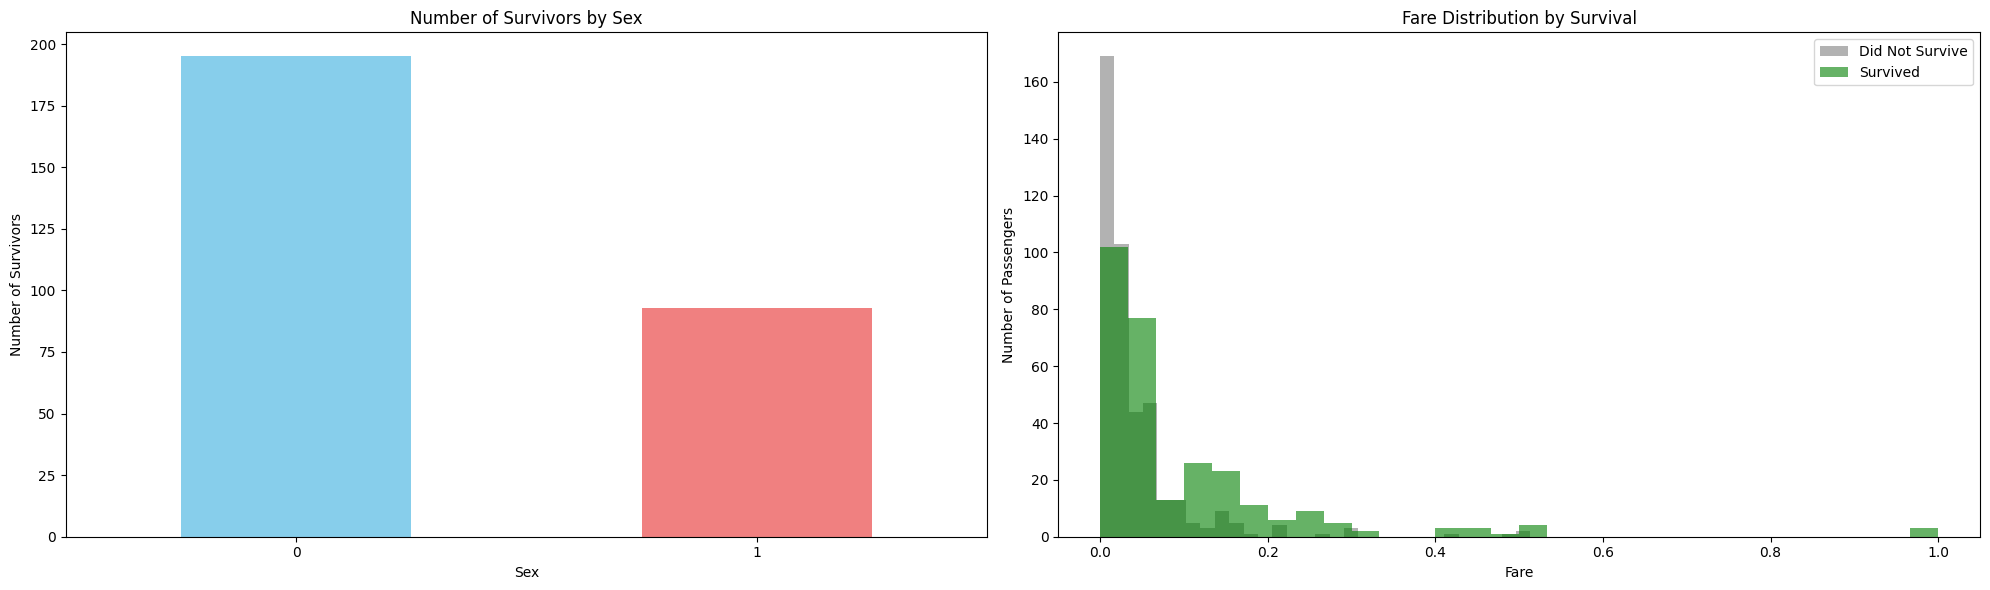

In [53]:
survived_by_sex = df.groupby('Sex')['Survived'].sum().sort_values(ascending=False)

fare_survived = df[df['Survived'] == 1]['Fare']
fare_not_survived = df[df['Survived'] == 0]['Fare']

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Bar chart
survived_by_sex.plot(kind='bar', color=['skyblue', 'lightcoral'], ax=axes[0])
axes[0].set_title('Number of Survivors by Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Number of Survivors')
axes[0].tick_params(axis='x', rotation=0)

# Right subplot: Histogram
axes[1].hist(fare_not_survived, bins=30, alpha=0.6, label='Did Not Survive', color='gray')
axes[1].hist(fare_survived, bins=30, alpha=0.6, label='Survived', color='green')
axes[1].set_title('Fare Distribution by Survival')
axes[1].set_xlabel('Fare')
axes[1].set_ylabel('Number of Passengers')
axes[1].legend()

plt.tight_layout()
plt.show()

## Actual AI stuff

In [8]:
# Normalize the fare
df_copy = df.copy()
df['Fare'] = df['Fare'] / df['Fare'].abs().max()
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,0.014151,1.0
1,1,1,0,38.0,1,0,0.139136,2.0
2,1,3,0,26.0,0,0,0.015469,1.0
3,1,1,0,35.0,1,0,0.103644,1.0
4,0,3,1,35.0,0,0,0.015713,1.0


In [9]:
# Create test training split
X = np.array(df.iloc[:, 1:])
Y = np.array(df.iloc[:, 0])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5)

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/df.shape[0],4)*100, "%") # Print testing shape

Training set is:  569  rows which is  79.92 %
Validation set is:  72  rows which is  10.11 %
Testing set is:  71  rows which is  9.969999999999999 %


In [10]:
# Create the Dataset object
class TitanicDataset:
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

In [11]:
train = TitanicDataset(X_train, Y_train)
test = TitanicDataset(X_test, Y_test)
valid = TitanicDataset(X_val, Y_val)

In [12]:
train_loader = DataLoader(train, batch_size=8, shuffle=True)
test_loader = DataLoader(test, batch_size=8, shuffle=True)
validation_loader = DataLoader(valid, batch_size=8, shuffle=True)

In [38]:
class TitanicPredictionModel(nn.Module):
  def __init__(self):
    super(TitanicPredictionModel, self).__init__()

    self.input = nn.Linear(X.shape[1], 20)
    self.linear = nn.Linear(20, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input(x)
    x = self.linear(x)
    return self.sigmoid(x)

In [39]:
model = TitanicPredictionModel().to(device)
# summary(model, (X.shape[0],))

In [40]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-2)

In [43]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(50):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()
        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs, labels in validation_loader:
            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()
            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(valid.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} \nTrain Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(valid.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 
Train Loss: 0.0332 Train Accuracy: 81.5466 Validation Loss: 0.0049 Validation Accuracy: 72.2222
Epoch no. 2 
Train Loss: 0.0355 Train Accuracy: 78.3831 Validation Loss: 0.0044 Validation Accuracy: 79.1667
Epoch no. 3 
Train Loss: 0.0346 Train Accuracy: 77.8559 Validation Loss: 0.0045 Validation Accuracy: 73.6111
Epoch no. 4 
Train Loss: 0.0328 Train Accuracy: 78.5589 Validation Loss: 0.0048 Validation Accuracy: 76.3889
Epoch no. 5 
Train Loss: 0.0345 Train Accuracy: 78.0316 Validation Loss: 0.0045 Validation Accuracy: 75.0000
Epoch no. 6 
Train Loss: 0.0350 Train Accuracy: 77.6801 Validation Loss: 0.0052 Validation Accuracy: 66.6667
Epoch no. 7 
Train Loss: 0.0350 Train Accuracy: 78.0316 Validation Loss: 0.0046 Validation Accuracy: 77.7778
Epoch no. 8 
Train Loss: 0.0361 Train Accuracy: 79.2619 Validation Loss: 0.0046 Validation Accuracy: 69.4444
Epoch no. 9 
Train Loss: 0.0331 Train Accuracy: 79.9649 Validation Loss: 0.0045 Validation Accuracy: 73.6111
Epoch no. 10 
Train

In [44]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 78.87%


In [45]:
data = torch.Tensor([ 2.0000,  0.0000, 17.0000,  0.0000,  0.0000,  0.0234,  2.0000]).to(device)

print(model(data).item())

0.9012599587440491


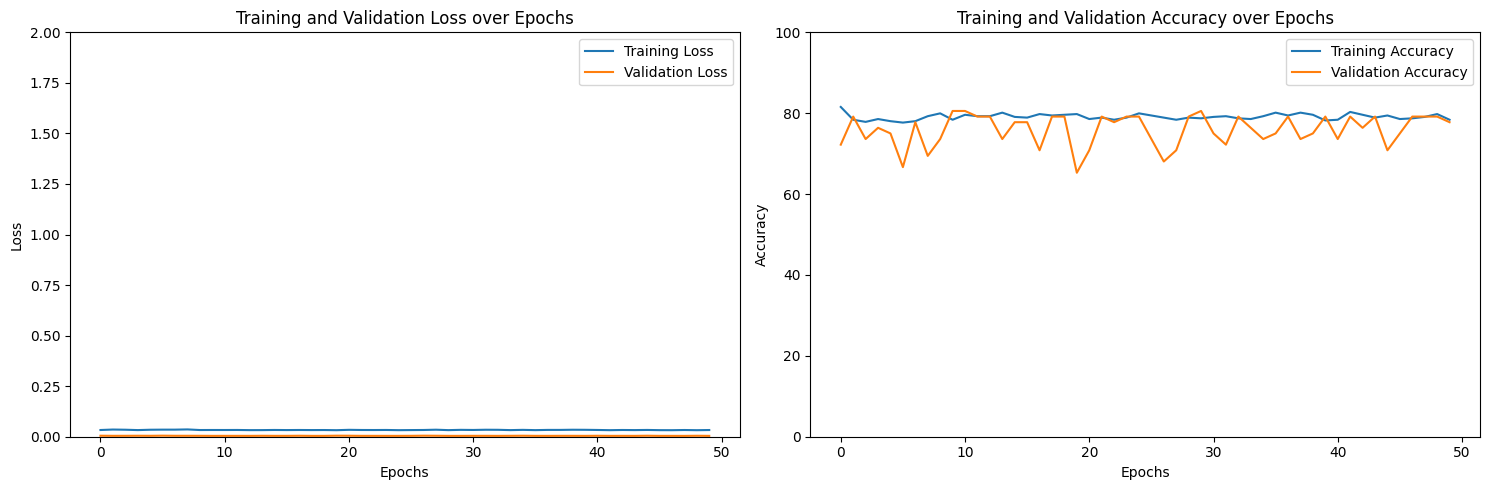

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [67]:
Pclass = 1
Sex = 1
Age = 60
SibSp = 2
Parch = 0
Fare = 20 / df['Fare'].abs().max()
Embarked = 0

inputs = [Pclass, Sex, Age, SibSp, Parch, Fare, Embarked]
model_inputs = torch.Tensor(inputs).to(device)
prediction = model(model_inputs)
print('=' * 20)
print(f'Pclass: {Pclass}')
print(f'Sex: {Sex}')
print(f'Age: {Age}')
print(f'SibSp: {SibSp}')
print(f'Parch: {Parch}')
print(f'Fare: {Fare}')
print(f'Embarked: {Embarked}')
print('=' * 20)
prediction.item()

Pclass: 1
Sex: 1
Age: 60
SibSp: 2
Parch: 0
Fare: 20.0
Embarked: 0


1.0